## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].sum()/290584

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.groupby(['group','landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

In [7]:
1928+1965

3893

f. Do any of the rows have missing values?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


No null

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2 = df.query("(group == 'control' and landing_page == 'old_page') or (group == 'treatment' and landing_page == 'new_page')")

In [10]:
df2

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2['user_id'].value_counts()

773192    2
630732    1
811737    1
797392    1
795345    1
801490    1
799443    1
787157    1
793302    1
817882    1
842446    1
815835    1
805596    1
803549    1
809694    1
807647    1
895712    1
840399    1
836301    1
899810    1
834242    1
936604    1
934557    1
940702    1
938655    1
830144    1
828097    1
832195    1
838348    1
821956    1
         ..
734668    1
736717    1
730574    1
775632    1
771538    1
642451    1
773587    1
783828    1
785877    1
779734    1
781783    1
759256    1
726472    1
748999    1
746950    1
753093    1
751044    1
740803    1
738754    1
744897    1
742848    1
634271    1
632222    1
636316    1
630169    1
650647    1
648598    1
654741    1
652692    1
630836    1
Name: user_id, Length: 290584, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [14]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2 = df2.drop_duplicates(['user_id'], keep='first')

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2['converted'].sum()

34753

In [17]:
34753/290583

0.11959749882133504

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [19]:
df2.groupby(['group','converted']).count()

user_id  timestamp  landing_page
group     converted                                  
control   0           127785     127785        127785
          1            17489      17489         17489
treatment 0           128046     128046        128046
          1            17264      17264         17264

In [20]:
17489/(127785+17489)

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [21]:
17264/(128046+17264)

0.11880806551510564

d. What is the probability that an individual received the new page?

In [22]:
df2['landing_page'].value_counts()

new_page    145310
old_page    145274
Name: landing_page, dtype: int64

In [23]:
145310/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

The control group that converted rate is slightly higher than the treatment group the converted.
I think that the information is not sufficient to concluded.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Null Hypothesis is the probability of old page is better than or equal to new page.

Alternative Hypothesis: The probability of new page being better than old page.

h0 = p_old >= p_new
h1 = p_new > p_old

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [24]:
pnew = df2['converted'].mean()
pnew

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [25]:
pold = df2['converted'].mean()
pold

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [26]:
nnew = df2[df2['group'] == 'treatment'].shape[0]

In [27]:
nnew

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [28]:
nold = df2[df2['group'] == 'control'].shape[0]

In [29]:
nold

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [30]:
new_page_converted = np.random.binomial(1,pnew,nnew)
new_page_converted

array([0, 1, 0, ..., 0, 0, 0])

In [31]:
new_page_converted.mean()

0.11946872204252977

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [32]:
old_page_converted = np.random.binomial(1,pold, nold)

In [33]:
old_page_converted.mean()

0.11980120324352603

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [34]:
new_page_converted.mean()-old_page_converted.mean()

-0.00033248120099625689

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [35]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(nnew, pnew)
    old_page_converted = np.random.binomial(nold, pold)
    diff = new_page_converted/nnew - old_page_converted/nold
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([    9.,    85.,   412.,  1341.,  2424.,  2747.,  1982.,   782.,
          190.,    28.]),
 array([-0.00460663, -0.00373045, -0.00285427, -0.00197809, -0.00110191,
        -0.00022574,  0.00065044,  0.00152662,  0.0024028 ,  0.00327898,
         0.00415516]),
 <a list of 10 Patch objects>)

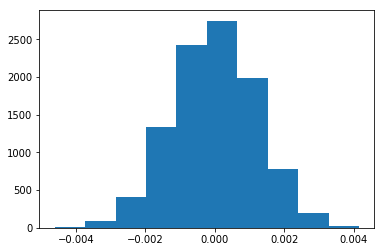

In [36]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [37]:
actual_diff = df2.query('landing_page == "new_page"').converted.mean() - df2.query('landing_page == "old_page"').converted.mean()
(p_diffs > actual_diff).mean()

0.90429999999999999

In [38]:
(p_diffs - actual_diff).mean()

0.0015736825586083437

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

It's p-value, a probability (extreme) that null hypothesis is true.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [39]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == "1"').count()[0]
convert_new = df2.query('landing_page == "new_page" & converted == "1"').count()[0]
n_old = df2.landing_page.value_counts()[1]
n_new = df2.landing_page.value_counts()[0]
convert_old, convert_new, n_old, n_new

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [40]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

In [41]:
from scipy.stats import norm
norm.cdf(z_score)

0.90505831275902449

In [42]:
norm.ppf(1-(0.05))

1.6448536269514722

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Yes, agree with J and K. Fail to reject null hypotesis becase the Z-score is lower than critical level and 
p-value is difference from calculation in J and K.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [43]:
df2[['control','ab_page']] = pd.get_dummies(df2['group'])

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [44]:
df2.head()

,user_id,timestamp,group,landing_page,converted,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [45]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 7 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
control         290584 non-null uint8
ab_page         290584 non-null uint8
dtypes: int64(2), object(3), uint8(2)
memory usage: 13.9+ MB


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [47]:
import statsmodels.api as sm

df2['intercept'] = 1

logit = sm.Logit(df2['converted'],df2[['intercept' ,'ab_page']])
results = logit.fit()


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [48]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-03-11 07:21 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

By keep other variables constant, the number of converted is more likely than those that are not converted. This means that the old page and new page are both equal in chance of converting users. We should not assume that the new page is better than the old page.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

The p-value found in the logistic regression model is 0.1899 which is different from part j and k. Because null and alternative hypthesis assumed that there is an equal probability of the old and new page converting users.
Logistic Regression performed is a two-tailed test, the computation done in Part II is a one-tailed test.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Other factors that influence whether an individual converts could be age, gender or region. Older users may prefer more information on the pages as opposed to a kid, where they may prefer more pictures and a more casual theme. Male and Female may have difference perspective and region as well.
Adding more factors into the regression model will increase or decrease confidence intervals.
A disadvantage of multiple factors in a logistic regression model is that it reduces the power of analysis.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

No impact. based on analysis below, no significant difference from previous.

In [49]:
df3 = pd.read_csv('countries.csv')
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [50]:
# create dummy variables
df3[['CA','UK', 'US']] = pd.get_dummies(df3['country'])

# drop country not necessary
df3 = df3.drop('country', 1)
df3.head()

,user_id,CA,UK,US
0,834778,0,1,0
1,928468,0,0,1
2,822059,0,1,0
3,711597,0,1,0
4,710616,0,1,0


In [51]:
new_df = df2.join(df3.set_index('user_id'), on='user_id')
new_df.head()

,user_id,timestamp,group,landing_page,converted,control,ab_page,intercept,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,0,1


In [52]:
mod = sm.Logit(new_df['converted'], new_df[['intercept', 'US', 'CA']])

results = mod.fit()

results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-03-11 07:21 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9868    0.0114  -174.1736  0.0000  -2.0092  -1.9645
US           -0.0099    0.0133    -0.7458  0.4558  -0.0360   0.0161
CA           -0.0507    0.0284    -1.7863  0.0740  -0.1064   0.0049
==================================================================

"""

In [53]:
1/np.exp(-0.0507), np.exp(-0.0099)

(1.0520072437650141, 0.99014884368295719)

US users are likely to less convert as compared to users from UK
CA users are likely to less convert as compared to users from UK and US

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [54]:
new_df['new_CA'] = new_df['CA']*new_df['ab_page']
new_df['new_UK'] = new_df['UK']*new_df['ab_page']
new_df['new_US'] = new_df['US']*new_df['ab_page']

new_df.head()

,user_id,timestamp,group,landing_page,converted,control,ab_page,intercept,CA,UK,US,new_CA,new_UK,new_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,0,0,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,0,0,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,0,1,0,0,0


In [55]:
lm = sm.OLS(new_df['converted'], new_df[['intercept', 'ab_page', 'UK', 'US', 'new_UK', 'new_US']])
results_new = lm.fit()
results_new.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:              OLS              Adj. R-squared:     0.000      
Dependent Variable: converted        AIC:                170541.0521
Date:               2021-03-11 07:23 BIC:                170604.5300
No. Observations:   290584           Log-Likelihood:     -85265.    
Df Model:           5                F-statistic:        1.466      
Df Residuals:       290578           Prob (F-statistic): 0.197      
R-squared:          0.000            Scale:              0.10529    
----------------------------------------------------------------------
               Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
----------------------------------------------------------------------
intercept      0.1188     0.0038   31.0570   0.0000    0.1113   0.1263
ab_page       -0.0069     0.0054   -1.2766   0.2018   -0.0174   0.0037
UK             0.0012     0.0042    0.2960   0.7672   -0.0070   0.0094
US             0.0018     0.0040    0.4667   0.6407   -0.0059   0.0096
new_UK         0.0080     0.0059    1.3599   0.1739   -0.0035   0.0196
new_US         0.0047     0.0056    0.8454   0.3979   -0.0062   0.0156
--------------------------------------------------------------------
Omnibus:             125549.436     Durbin-Watson:        1.995     
Prob(Omnibus):       0.000          Jarque-Bera (JB):     414285.945
Skew:                2.345          Prob(JB):             0.000     
Kurtosis:            6.497          Condition No.:        26        
====================================================================

"""

There is no signficant effect on the conversation.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])